## Step 1

#### 1. Does put-call parity apply for European options? Why or why not?

Yes, put-call parity applies for European options. The put-call parity states that the difference between the price of a European call option and a European put option with the same underlying asset, strike price, and expiration date should be equal to the present value of the strike price. This relationship holds for European options because European options can only be exercised at expiration.

#### 2. Rewrite put-call parity to solve for the call price in terms of everything else.

The put-call parity can be written to solve for the call price as follows: 

$$
\begin{align}
C &= P + S - Ke^{-rT} \nonumber \\[5pt]
\text{where,} \nonumber \\[3pt]
C &= \text{call price} \nonumber \\
P &= \text{put price} \nonumber \\
S &= \text{underlying asset price} \nonumber\\
K &= \text{strike price} \nonumber \\
r &= \text{risk-free interest rate} \nonumber \\
T &= \text{time to expiration} \nonumber
\end{align}
$$


#### 3. Rewrite put-call parity to solve for the put price in terms of everything else.

The put-call parity can also be written to solve for the put price as follows:

$$
\begin{align}
P &= C - S + Ke^{-rT} \nonumber \\[5pt]
\text{where,} \nonumber \\[3pt] 
C &= \text{call price} \nonumber \\
P &= \text{put price} \nonumber \\
S &= \text{underlying asset price} \nonumber \\
K &= \text{strike price} \nonumber \\
r &= \text{risk-free interest rate} \nonumber \\
T &= \text{time to expiration} \nonumber
\end{align}
$$


#### 4. Does put-call parity apply for American options? Why or why not?

No, put-call parity does not apply for American options. American options can be exercised at any time prior to expiration, whereas European options can only be exercised at expiration. Because of this extra optionality, American options can be worth more than European options with the same underlying, strike price, and expiration. This means that the relationship between the call price and put price for American options may differ from that of European options, so put-call parity may not hold for American options.

$
\begin{align}
\hspace{1cm}S_0 &= 100 \nonumber \\
\hspace{1cm}r &= 5\% \nonumber \\
\hspace{1cm}\sigma &= 20\% \nonumber \\
\hspace{1cm}T &= 3 months \nonumber \\
\end{align}
$

Below is a python class, which can be used to compute prices and deltas for the upcoming tasks.

In [35]:
import numpy as np
import matplotlib.pyplot as plt

class OptionPricing:
    '''
    A class that computes the option price of European/American/Asian options using binomial/trinomial pricing approach
    
    parameters:
    -----------
    S_0: Value of the underlying asset
    K: Strike price
    sigma: Volatility of the underlying asset
    T: Time to maturity (in years)
    N: Number of steps in the tree
    r: risk-free rate of interest
    option_type: 
            values: call / put
    option_style:
            values: European / American / Asian
            
    Methods:
    --------
    binomial_pricing(): 
        Uses the binomial pricing model to price the option with the given parameters.
        Returns a tuple of 4 elements.
            1. The option price, discounted to time t=0.
            2. A numpy array of the price evolution using Binomial model upto time T with N number of steps.
            3. A numpy array of the option price at each step in the tree (which can be essential in pricing the Asian option).
            4. A numpy array with deltas at each node until expiration.
            
    trinomial_pricing():
        Uses the trinomial pricing model to price the option with the given parameters.
        Returns a tuple of 3 elements.
            1. Option price, discounted to time t=0.
            2. Numpy array of the price evolution using Trinomial model upto time T with N number of steps.
            3. Numpy array ot the option price at each step in the tree
    '''
    def __init__(self, S_0, K, sigma, T, N, r, option_type, option_style):
        self.S_0 = S_0
        self.K = K
        self.sigma = sigma
        self.T = T
        self.N = N
        self.r = r
        self.dt = T / N
        self.option_type = option_type
        self.option_style = option_style
        self.discount = np.exp(-self.r * self.dt)
        
    def __traverse_backward(self, arr, i, j, results):
        if i < 0 or j < 0:
            return
        if arr[i][j] == 0:
            self.__traverse_backward(arr, i-1, j, results)
        else:
            results.append(arr[i][j])
            self.__traverse_backward(arr, i, j-1, results)
        return results
            
    
    def binomial_pricing(self):
        self.u = np.exp(self.sigma * np.sqrt(self.dt))
        self.d = np.exp(-self.sigma * np.sqrt(self.dt))
        self.p = (np.exp(self.r * self.dt) - self.d) / (self.u - self.d)
        self.S_t = np.zeros([self.N + 1, self.N + 1])
        self.Op = self.S_t.copy()
        self.delta = np.zeros([self.N, self.N])
        
        if self.option_style != "Asian":
            for i in range(self.N, -1, -1):
                for j in range(i, -1, -1):
                    self.S_t[j, i] = self.S_0 * self.u ** (i-j) * self.d ** j
                    if self.option_type == "call":
                        self.Op[j, i] = max(self.S_t[j,i] - self.K, 0)
                    elif self.option_type == "put":
                        self.Op[j, i] = max(self.K - self.S_t[j,i], 0)    
                    if i < self.N:
                        if self.option_style == "European":
                            self.Op[j, i] = self.discount * (self.p * self.Op[j, i+1] + (1-self.p) * self.Op[j+1, i+1])

                        elif self.option_style == "American":
                            at_maturity = self.discount * (self.p * self.Op[j, i+1] + (1-self.p) * self.Op[j+1, i+1])
                            early = self.Op[j, i]
                            self.Op[j, i] = max(at_maturity, early)

                        self.delta[j, i] = (self.Op[j, i+1] - self.Op[j+1, i+1]) / (self.S_t[j, i+1] - self.S_t[j+1, i+1])

            return np.round(self.Op[0,0], 2), np.round(self.S_t, 2), np.round(self.Op, 2), np.round(self.delta, 2)    
        
        else:
            
            for i in range(self.N, -1, -1):
                for j in range(i, -1, -1):
                    self.S_t[j, i] = self.S_0 * self.u ** (i-j) * self.d ** j
            
            mean_list = []
            
            for i in range(1, self.S_t.shape[1]+1):
                mean_list.append(np.mean(self.__traverse_backward(self.S_t[:i], self.S_t[:i].shape[0]-1, self.S_t.shape[1]-1, [])))
                
            if self.option_type == "call":
                payoff = [max(mean_list[i] - self.K, 0) for i in range(len(mean_list))]

            
            elif self.option_type == "put":
                payoff = [max(self.K - mean_list[i], 0) for i in range(len(mean_list))]
                
            self.Op[:,-1] = payoff
            
            for i in range(self.N-1, -1, -1):
                for j in range(i, -1, -1):
                    self.Op[j, i] = self.discount * (self.p * self.Op[j, i+1] + (1-self.p) * self.Op[j+1, i+1])
                
            return np.round(payoff, 2), np.round(self.Op, 2)
        
    
    def trinomial_pricing(self):
        self.u = np.exp(self.sigma * np.sqrt(2*self.dt))
        self.d = np.exp(-self.sigma * np.sqrt(2*self.dt))
        self.pu = ((np.exp(self.r * self.dt / 2) - np.exp(-self.sigma * np.sqrt(self.dt/2)))\
                    / (np.exp(self.sigma * np.sqrt(self.dt/2)) - np.exp(-self.sigma * np.sqrt(self.dt/2)))) ** 2
        self.pd = ((-np.exp(self.r * self.dt / 2) + np.exp(self.sigma * np.sqrt(self.dt/2)))\
                    / (np.exp(self.sigma * np.sqrt(self.dt/2)) - np.exp(-self.sigma * np.sqrt(self.dt/2)))) ** 2
        self.pm = 1 - self.pu - self.pd
        
        self.S_t = np.zeros([2 * self.N + 1, self.N + 1])
        
        self.Op = self.S_t.copy()
        
        self.S_t[self.N, 0] = self.S_0
        
        for i in range(1, self.N + 1):
            for j in range(self.N - i, self.N + i + 1):
                if j == self.N - i:
                    self.S_t[j, i] = self.S_t[j + 1, i - 1] * self.u
                elif j == self.N + i:
                    self.S_t[j, i] = self.S_t[j - 1, i - 1] * self.d
                else:
                    self.S_t[j, i] = self.S_t[j, i - 1]
        
        for i in range(self.N, -1, -1):
            for j in range(self.N - i, self.N + i + 1):
                if self.option_type == "call":
                    self.Op[j, i] = max(self.S_t[j, i] - self.K, 0)
                elif self.option_type == "put":
                    self.Op[j, i] = max(self.K - self.S_t[j, i], 0)
                if i < self.N:
                    if self.option_style == "European":
                        self.Op[j, i] = self.discount * (self.pu * self.Op[j-1, i+1] + self.pm * self.Op[j, i+1] + self.pd * self.Op[j+1, i+1])
                    elif self.option_style == "American":
                        at_maturity = self.discount * (self.pu * self.Op[j-1, i+1] + self.pm * self.Op[j, i+1] + self.pd * self.Op[j+1, i+1])
                        early = self.Op[j, i]
                        self.Op[j, i] = max(at_maturity, early)

        return np.round(self.Op[self.N, 0], 2), np.round(self.S_t, 2), np.round(self.Op, 2)
    
    def __repr__(self):
        st = f"{self.option_style} option \nPrice of underlying: {self.S_0} \nStrike Price: {self.K}"
        return st

#### 5. Price an ATM European call and put using a binomial tree:
##### a. Choose the number of steps in the tree you see convenient to achieve reliable estimates.

To achieve a reliable estimate of the number of steps, we will compute the option price using N in a range from 1 to 200. The best number of steps would be the number where the option price converges with a reliable approximation.

In [36]:
OptionPricing(120, 120, 0.3, 8/12, 100, 0.05, "call", "European").binomial_pricing()[0]

13.55

In [2]:
S_0 = 100
K = 100
r = 0.05
sigma = 0.20
T = 3/12

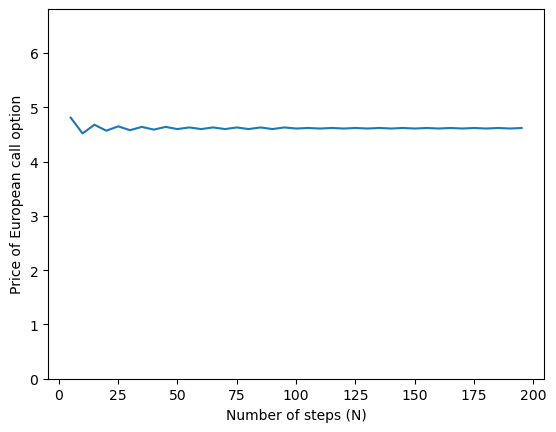

In [3]:
# European call price

european_call_prices = [OptionPricing(S_0, K, sigma, T, i, r, "call", "European")
                        .binomial_pricing()[0] for i in range(5, 200, 5)]

plt.plot(range(5, 200, 5), european_call_prices)
plt.ylim(0, max(european_call_prices) + 2)
plt.ylabel("Price of European call option")
plt.xlabel("Number of steps (N)")

plt.show()

$N = 50$ seems to be a reliable estimate as the price converge significantly.

In [4]:
european_call_price = european_call_prices[(50-5)//5]
print(f"Price of European call using a binomial tree: {european_call_price}")

Price of European call using a binomial tree: 4.6


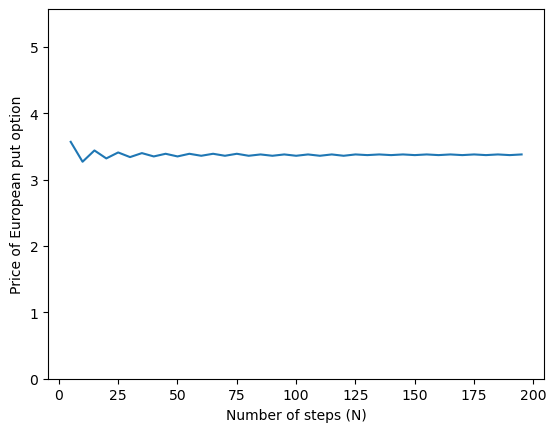

In [5]:
# European put option

european_put_prices = [OptionPricing(S_0, K, sigma, T, i, r, "put", "European")
                        .binomial_pricing()[0] for i in range(5, 200, 5)]

plt.plot(range(5, 200, 5), european_put_prices)
plt.ylim(0, max(european_put_prices) + 2)
plt.ylabel("Price of European put option")
plt.xlabel("Number of steps (N)")

plt.show()

Again, at $N = 50$, the price converge.

In [6]:
european_put_price = european_put_prices[(50-5)//5]
print(f"Price of European put using a binomial tree: {european_put_price}")

Price of European put using a binomial tree: 3.35


##### b. Briefly describe the overall process, as well as a reason why you choose that number of steps in the tree.

* We start by specifying current price of underlying asset, option's strike price, time to expiration, volatility, call/put as the inputs. 

* Current price of underlying is used to construct the evolution of the asset over time t, considering two steps (up/down) at each node, to form a binomial tree.

* Next we compute the option's payoff at expiration for each possible price path of the underlying asset.

* Then, we do backward induction upto present and discount them using risk-free interest rate to obtain the option's fair value.

* The number of steps in the tree is estimated by pricing the options using different steps in the range 5-200 with the step of 5. We then plotted the prices to find the optimal number of steps, where the prices converge to desirable level, also being aware of the computational complexity.

#### 6. Compute the Greek Delta for the European call and European put at time 0:

In [7]:
european_call_delta = OptionPricing(S_0, K, sigma, T, 50, r, "call", "European").binomial_pricing()[3][0, 0]

print(f"Delta of European call at time 0: {european_call_delta}")

Delta of European call at time 0: 0.57


In [8]:
european_put_delta = OptionPricing(S_0, K, sigma, T, 50, r, "put", "European").binomial_pricing()[3][0, 0]

print(f"Delta of European put at time 0: {european_put_delta}")

Delta of European put at time 0: -0.43


##### a. How do they compare?

At time 0, the delta of a call option is positive (0.57), while the delta of put option is negative (0.43).

##### b. Comment briefly on the differences and signs of Delta for both options.What does delta proxy for? Why does it make sense to obtain a positive/negative delta for each option?

* Delta of an option represents the change in option's price for a small change in the underlying asset price. 
* A positive Delta indicates that the option price increases when the underlying asset price increases, while a negative delta indicates the opposite. 
* The Delta for a call option is always positive, because the option becomes more valuable as the underlying asset price increases, while the Delta for a put option is always negative, because the option becomes more valuable as the underlying asset price decreases.

#### 7. Delta measures one sensitivity of the option price. But there are other important sensitivities we will look at throughout the course. An important one is the sensitivity of the option price to the underlying volatility (vega).

##### a. Compute the sensitivity of previous put and call option prices to a 5% increase in volatility (from 20% to 25%). How do prices change with respect to the change in volatility?

In [9]:
call_price_at_20 = OptionPricing(S_0, K, 0.20, T, 50, r, "call", "European").binomial_pricing()[0]
call_price_at_25 = OptionPricing(S_0, K, 0.25, T, 50, r, "call", "European").binomial_pricing()[0]
put_price_at_20 = OptionPricing(S_0, K, 0.20, T, 50, r, "put", "European").binomial_pricing()[0]
put_price_at_25 = OptionPricing(S_0, K, 0.25, T, 50, r, "put", "European").binomial_pricing()[0]

print(f'''
Call price at 20% volatility:{call_price_at_20}
Call price at 25% volatility:{call_price_at_25}
Put price at 20% volatility:{put_price_at_20}
Put price at 25% volatility:{put_price_at_25}
''')


Call price at 20% volatility:4.6
Call price at 25% volatility:5.57
Put price at 20% volatility:3.35
Put price at 25% volatility:4.33



##### b. Comment on the potential differential impact of this change for call and put options.

For both call and put option, the price increases with the increase in volatility. This is because, the increase in volatiliy increases the probability of the underlying asset price moving in either direction at expiration, increasing the potential profit for both call and put option.

#### 8. Price an ATM American call and put using a binomial tree:
##### a. Choose the number of steps in the tree you see convenient to achieve reliable estimates.

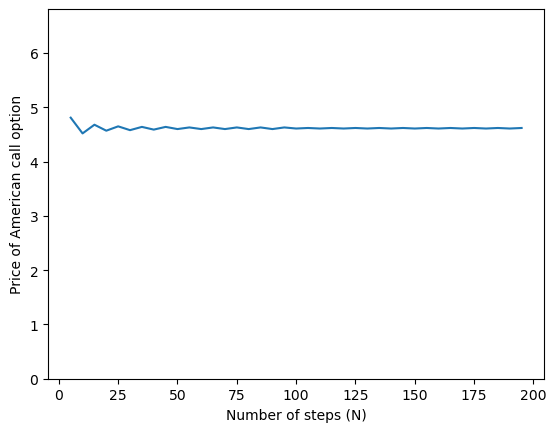

In [10]:
# American call price

american_call_prices = [OptionPricing(S_0, K, sigma, T, i, r, "call", "American")
                        .binomial_pricing()[0] for i in range(5, 200, 5)]

plt.plot(range(5, 200, 5), american_call_prices)
plt.ylim(0, max(american_call_prices) + 2)
plt.ylabel("Price of American call option")
plt.xlabel("Number of steps (N)")

plt.show()

In [11]:
american_call_price = american_call_prices[(50-5)//5]
print(f"Price of American call using a binomial tree: {american_call_price}")

Price of American call using a binomial tree: 4.6


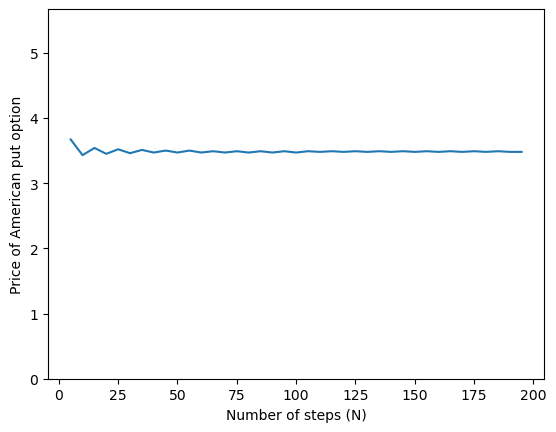

In [12]:
# American put price

american_put_prices = [OptionPricing(S_0, K, sigma, T, i, r, "put", "American")
                        .binomial_pricing()[0] for i in range(5, 200, 5)]

plt.plot(range(5, 200, 5), american_put_prices)
plt.ylim(0, max(american_put_prices) + 2)
plt.ylabel("Price of American put option")
plt.xlabel("Number of steps (N)")

plt.show()

In [13]:
american_put_price = american_put_prices[(50-5)//5]
print(f"Price of American put using a binomial tree: {american_put_price}")

Price of American put using a binomial tree: 3.47


To price an ATM American call and put using a binomial tree, one convenient number of steps could be 50 steps. This number of steps would provide a relatively accurate estimate of the option prices while still being computationally manageable.

##### b. Briefly describe the overall process, as well as a reason why you choose that number of steps in the tree.
The overall process would involve building a binomial tree that follows the evolution of the underlying asset price over time. At each step, the underlying asset price would either increase or decrease by a certain amount, based on the volatility and the risk-free interest rate. The option prices would then be calculated by working backwards from the final step and taking into account the option's intrinsic value and the expected pay-outs at each node.

#### 9. Compute the Greek Delta for the American call and American put at time 0:

In [14]:
american_call_delta = OptionPricing(S_0, K, sigma, T, 50, r, "call", "American").binomial_pricing()[3][0, 0]

print(f"Delta of American call at time 0: {american_call_delta}")

Delta of American call at time 0: 0.57


In [15]:
american_put_delta = OptionPricing(S_0, K, sigma, T, 50, r, "put", "American").binomial_pricing()[3][0, 0]

print(f"Delta of American put at time 0: {american_put_delta}")

Delta of American put at time 0: -0.45


##### a. How do they compare?

The Delta for the American call and American put at time 0 is positive (0.57) and negative (-0.45), respectively. The Delta for the call option represents the change in the option price with respect to a small change in the underlying asset price, while the Delta for the put option represents the opposite relationship.

##### b. Comment briefly on the differences and signs of Delta for both options. What does delta proxy for? Why does it make sense to obtain a positive/negative delta for each option?

The Delta of a call option is an estimate of the rate of change of the option price with respect to the underlying asset price. It gives us a sense of how much the option price will change for a unit change in the underlying asset price. On the other hand, the Delta of a put option is negative, meaning that the price of the option will decrease as the underlying asset price increases. Delta is commonly referred to as the "hedge ratio" and it represents the proportion of the underlying asset that one should hold in a portfolio to hedge against changes in the option price. Delta acts as a proxy for the likelihood that the option will be exercised. The difference and signs of Delta for both options make sense because the call option benefits from an increase in the underlying asset price, while the put option benefits from a decrease in the underlying asset price. If Delta is positive, it means that the call option price is sensitive to changes in the underlying asset price, and thus, one should hold a positive position in the underlying asset. If Delta is negative, it means that the put option price is sensitive to changes in the underlying asset price, and thus, one should hold a negative position in the underlying asset.

#### 10. Delta measures one sensitivity of the option price. But there are other important sensitivities we will look at throughout the course. An important one is the sensitivity of the option price to the underlying volatility (vega).

##### a. Compute the sensitivity of previous put and call option prices to a 5% increase in volatility (from 20% to 25%). How do prices change with respect to the change in volatility?

In [16]:
call_price_at_20 = OptionPricing(S_0, K, 0.20, T, 50, r, "call", "American").binomial_pricing()[0]
call_price_at_25 = OptionPricing(S_0, K, 0.25, T, 50, r, "call", "American").binomial_pricing()[0]
put_price_at_20 = OptionPricing(S_0, K, 0.20, T, 50, r, "put", "American").binomial_pricing()[0]
put_price_at_25 = OptionPricing(S_0, K, 0.25, T, 50, r, "put", "American").binomial_pricing()[0]

print(f'''
Call price at 20% volatility:{call_price_at_20}
Call price at 25% volatility:{call_price_at_25}
Put price at 20% volatility:{put_price_at_20}
Put price at 25% volatility:{put_price_at_25}
''')


Call price at 20% volatility:4.6
Call price at 25% volatility:5.57
Put price at 20% volatility:3.47
Put price at 25% volatility:4.45



Considering American-style options, a 5% increase in volatility from 20% to 25% would increase the price of both the call and put options. This is because an increase in volatility increases the uncertainty about the future price of the underlying asset, which makes the options more valuable. 

##### b. Comment on the potential differential impact of this change for call and put options.

The potential differential impact of a change in volatility would depend on the initial price and delta of the call and put options. A call option with a higher initial price and delta would see a larger increase in price with a change in volatility than a put option with a lower initial price and delta.


#### 11. If the team answered Q1 as “Yes” (i.e. that put-call parity holds), then show that the European call and put satisfy put-call parity. Comment on the reasons why/why not the parity holds, as well as potential motives.

Yes, for a European option, put-call parity holds.

$$ c_0 + Ke^{-rT} = S_0 + p_0 $$

In [17]:
c_0 = european_call_price
p_0 = european_put_price

assert np.round(c_0 + K*np.exp(-r*T), 1) == np.round(S_0 + p_0, 1)

print(f"LHS: {np.round(c_0 + K*np.exp(-r*T), 2)}")
print(f"RHS: {np.round(S_0 + p_0, 2)}")

LHS: 103.36
RHS: 103.35


We can see the put-call parity hold for the European option because if we have two portfolios (one has a European call option and the other has a European put option)they will end with the same payoff regardless of the movement of underlying price (up or down). The motive behind this is to eliminate arbitrage opportunities.

#### 12. If the team answered Q4 as “Yes” (i.e. that put-call parity holds), then show that the American call and put satisfy put-call parity. Comment on the reasons why/why not the parity holds, as well as potential motives.

No, for an American option, put-call parity does not hold.

In [18]:
C_0 = american_call_price
P_0 = american_put_price

assert np.round(C_0 + K*np.exp(-r*T), 1) != np.round(S_0 + P_0, 1)

print(f"LHS: {np.round(C_0 + K*np.exp(-r*T), 2)}")
print(f"RHS: {np.round(S_0 + P_0, 2)}")

LHS: 103.36
RHS: 103.47


We can see the put-call parity does not hold for the American option because they can exercise any time up to the expiry date. American options are considered high risk because of the uncertainty.

#### 13. Confirm that the European call is less than or equal to the American call. Show the difference if any and comment on the reasons for this difference, would this always be the case?

| | European | American |
| --- | --- | --- |
| **call** | 4.6 | 4.6 |

Yes, the European call is always less than or equal to the American call, here we see the European call equal to the American call. If you cannot take profits from the early exercise, the two options will expire at the same value.

The payoff for American call options:

$ \hspace{1cm}C_0 = (0, S_0 - K) $

The payoff for European call options.

$ \hspace{1cm} c_0 \le (0, S_0 - Ke^{-rt}) $

So, we can see American call price is always equal to or greater than the European call price.

#### 14. Confirm that the European put is less than or equal to the American put. Show the difference if any and comment on the reasons for this difference. For example, would this always be the case?

| | European | American |
| --- | --- | --- |
| **put** | 3.35 | 3.47 |

Yes, the European put is less than or equal to the American put and the difference is (3.43-3.27= 0.15). We note that the American put price exceeds the price of the European put option, so there is a motive for early exercise when it is deep in the money and the discount factor reduces volatility.

The payoff for American put options:

$ \hspace{1cm}C_0 = (0, K - S_0) $

The payoff for European call options.

$ \hspace{1cm}c_0 \le (0, Ke^{-rt} - S_0) $

So, we can see American put price is never less than the European put price.

## Step 2

#### 15. Select 5 strike prices so that Call options are: Deep OTM, OTM, ATM, ITM, and Deep ITM.

##### a. Using the trinomial tree, price the European Call option corresponding to the 5 different strikes selected. 

The five strike prices selected for the Call options are:

|| S<sub>0</sub> | Moneyness | K |
|---| --- | --- | --- |
| **Deep OTM** | 100 | 1.4 | 140 |
| **OTM** | 100 | 1.2 | 120 |
| **ATM** | 100 | 1.0 | 100 |
| **ITM** | 100 | 0.8 | 80 |
| **Deep ITM** | 100 | 0.6 | 60 |


In [19]:
deep_otm_K = 1.4 * S_0 
otm_K = 1.2 * S_0
atm_K = S_0
itm_K = 0.8 * S_0
deep_itm_K = 0.6 * S_0

eu_call_price_list = []

for i in [deep_otm_K, otm_K, atm_K, itm_K, deep_itm_K]:
    eu_call_price_list.append(OptionPricing(S_0, i, sigma, T, 50, r, "call", "European").trinomial_pricing()[0])
    
print(f"The prices of the European Call options corresponding to the five strikes selected: \n\n{eu_call_price_list}")

The prices of the European Call options corresponding to the five strikes selected: 

[0.0, 0.2, 4.61, 21.02, 40.75]


##### b. Comment on the trend you observe (e.g., increasing/decreasing in moneyness) in option prices and whether it makes sense.

The trend observed in the option prices is that the deeper ITM the option is, the higher the price. This trend makes sense as the probability of the option finishing in the money increases as the option gets deeper ITM. Additionally, the time value of the option decreases as it gets deeper ITM, which also contributes to the higher option price.

#### 16. Select 5 strike prices so that Put options are: Deep OTM, OTM, ATM, ITM, and Deep ITM.

##### a. Using the trinomial tree, price the European Put option corresponding to the 5 different strikes selected. 

The five strike prices selected for the Put options are:

|| S<sub>0</sub> | Moneyness | K |
|---| --- | --- | --- |
| **Deep OTM** | 100 | 0.6 | 60 |
| **OTM** | 100 | 0.8 | 80 |
| **ATM** | 100 | 1.0 | 100 |
| **ITM** | 100 | 1.2 | 120 |
| **Deep ITM** | 100 | 1.4 | 140 |


In [34]:
deep_otm_K = 0.6 * S_0 
otm_K = 0.8 * S_0
atm_K = S_0
itm_K = 1.2 * S_0
deep_itm_K = 1.4 * S_0

eu_put_price_list = []

for i in [deep_otm_K, otm_K, atm_K, itm_K, deep_itm_K]:
    eu_put_price_list.append(OptionPricing(S_0, i, sigma, T, 50, r, "put", "European").trinomial_pricing()[0])
    
print(f"The prices of the European Put options corresponding to the five strikes selected: \n\n{eu_put_price_list}")

The prices of the European Put options corresponding to the five strikes selected: 

[0.0, 0.03, 3.36, 18.71, 38.26]


##### b. Comment on the trend you observe (e.g., increasing/decreasing in moneyness) in option prices and whether it makes sense.

The trend observed in the option prices is that the deeper ITM the option is, the higher the price. This trend makes sense as the probability of the option finishing in the money increases as the option gets deeper ITM. Additionally, the time value of the option decreases as it gets deeper ITM, which also contributes to the higher option price.

#### 17. Select 5 strike prices so that Call options are: Deep OTM, OTM, ATM, ITM, and Deep ITM.

##### a. Using the trinomial tree, price the American Call option corresponding to the 5 different strikes selected. 

The five strike prices selected for the Call options are:

|| S<sub>0</sub> | Moneyness | K |
|---| --- | --- | --- |
| **Deep OTM** | 100 | 1.4 | 140 |
| **OTM** | 100 | 1.2 | 120 |
| **ATM** | 100 | 1.0 | 100 |
| **ITM** | 100 | 0.8 | 80 |
| **Deep ITM** | 100 | 0.6 | 60 |

In [22]:
deep_otm_K = 1.1 * S_0 
otm_K = 1.05 * S_0
atm_K = S_0
itm_K = 0.95 * S_0
deep_itm_K = 0.9 * S_0

am_call_price_list = []

for i in [deep_otm_K, otm_K, atm_K, itm_K, deep_itm_K]:
    am_call_price_list.append(OptionPricing(S_0, i, sigma, T, 50, r, "call", "American").trinomial_pricing()[0])
    
print(f"The prices of the American Call options corresponding to the five strikes selected: \n\n{am_call_price_list}")

The prices of the American Call options corresponding to the five strikes selected: 

[1.19, 2.49, 4.61, 7.72, 11.67]


##### b. Comment on the trend you observe (e.g., increasing/decreasing in moneyness) in option prices and whether it makes sense.

The trend observed is an increase in price as the strike is deeper in the money. This makes sense as the profit potential of the call option holder is very much higher when the strike is in the money which increases the price of the option.

#### 18. Select 5 strike prices so that Put options are: Deep OTM, OTM, ATM, ITM, and Deep ITM.

##### a. Using the trinomial tree, price the American Put option corresponding to the 5 different strikes selected. 

The five strike prices selected for the Put options are:

|| S<sub>0</sub> | Moneyness | K |
|---| --- | --- | --- |
| **Deep OTM** | 100 | 0.6 | 60 |
| **OTM** | 100 | 0.8 | 80 |
| **ATM** | 100 | 1.0 | 100 |
| **ITM** | 100 | 1.2 | 120 |
| **Deep ITM** | 100 | 1.4 | 140 |


In [28]:
deep_otm_K = 0.8 * S_0 
otm_K = 0.90 * S_0
atm_K = S_0
itm_K = 1.05 * S_0
deep_itm_K = 1.1 * S_0

am_put_price_list = []

for i in [deep_otm_K, otm_K, atm_K, itm_K, deep_itm_K]:
    am_put_price_list.append(OptionPricing(S_0, i, sigma, T, 50, r, "put", "American").trinomial_pricing()[0])
    
print(f"The prices of the American Put options corresponding to the five strikes selected: \n\n{am_put_price_list}")

The prices of the American Put options corresponding to the five strikes selected: 

[0.03, 0.56, 3.47, 6.43, 10.33]


##### b. Comment on the trend you observe (e.g., increasing/decreasing in moneyness) in option prices and whether it makes sense.

Similar to the call option, the price of the put option increases as the strike price is deeper in the money. This is because, the ATM and ITM swaps based on call/put. 

When the strike price is higher than the price of underlying asset, it is an OTM option in case of a call, but an ITM option in case of a put and vice versa. 

#### 19. Graph European call prices and put prices versus stock prices.

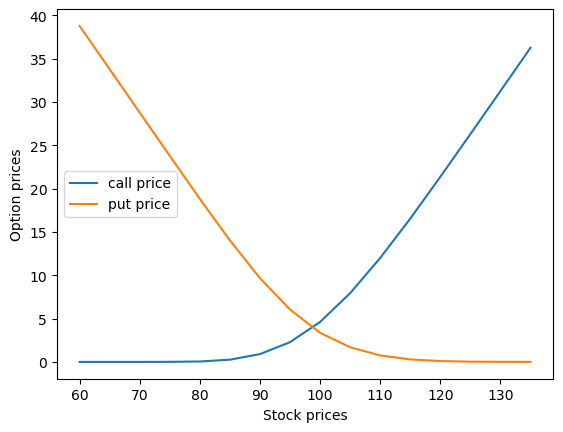

In [23]:
stock_prices = np.arange(60, 140, 5)

eu_call_price = [OptionPricing(i, K, sigma, T, 50, r, "call", "European").trinomial_pricing()[0] for i in stock_prices]
eu_put_price = [OptionPricing(i, K, sigma, T, 50, r, "put", "European").trinomial_pricing()[0] for i in stock_prices]

plt.plot(stock_prices, eu_call_price, label="call price")
plt.plot(stock_prices, eu_put_price, label="put price")

plt.legend()

plt.xlabel("Stock prices")
plt.ylabel("Option prices")

plt.show()

<div style="page-break-after: always;"></div>

#### 20. Graph American call prices and put prices versus stock prices.

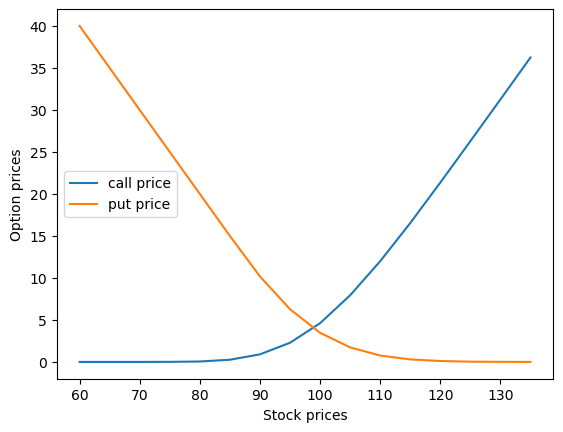

In [24]:
stock_prices = np.arange(60, 140, 5)

am_call_price = [OptionPricing(i, K, sigma, T, 50, r, "call", "American").trinomial_pricing()[0] for i in stock_prices]
am_put_price = [OptionPricing(i, K, sigma, T, 50, r, "put", "American").trinomial_pricing()[0] for i in stock_prices]

plt.plot(stock_prices, am_call_price, label="call price")
plt.plot(stock_prices, am_put_price, label="put price")

plt.legend()

plt.xlabel("Stock prices")
plt.ylabel("Option prices")

plt.show()

#### 21. Graph European and American call prices versus strike.

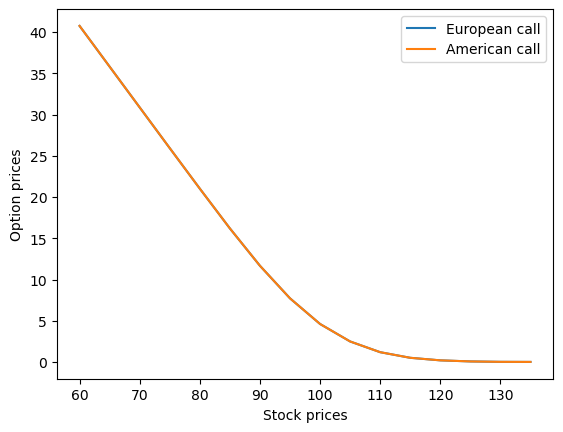

In [25]:
strike = np.arange(60, 140, 5)

eu_call_price = [OptionPricing(S_0, i, sigma, T, 50, r, "call", "European").trinomial_pricing()[0] for i in strike]
am_call_price = [OptionPricing(S_0, i, sigma, T, 50, r, "call", "American").trinomial_pricing()[0] for i in strike]

plt.plot(strike, eu_call_price, label="European call")
plt.plot(strike, am_call_price, label="American call")

plt.legend()

plt.xlabel("Stock prices")
plt.ylabel("Option prices")

plt.show()

<div style="page-break-after: always;"></div>

#### 22. Graph European and American put prices versus strike.

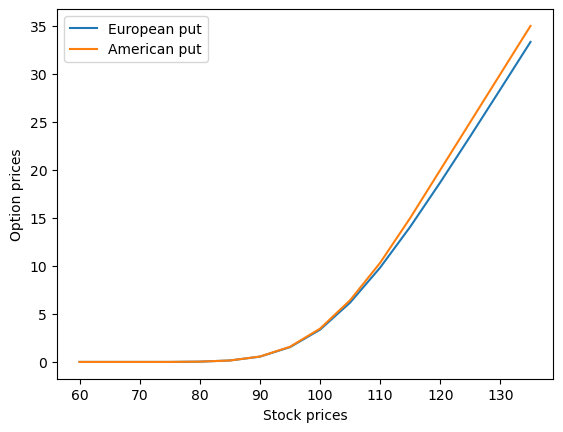

In [26]:
strike = np.arange(60, 140, 5)

eu_put_price = [OptionPricing(S_0, i, sigma, T, 50, r, "put", "European").trinomial_pricing()[0] for i in strike]
am_put_price = [OptionPricing(S_0, i, sigma, T, 50, r, "put", "American").trinomial_pricing()[0] for i in strike]

plt.plot(strike, eu_put_price, label="European put")
plt.plot(strike, am_put_price, label="American put")

plt.legend()

plt.xlabel("Stock prices")
plt.ylabel("Option prices")

plt.show()

#### 23. For the 5 strikes that your group member computed in Q15 and Q16, check whether put-call parity holds (within sensible rounding). Briefly comment on the reasons why/why not this is the case.

In [27]:
strikes = [60, 80, 100, 120, 140]

for i in range(5):
    print(f"LHS: {np.round(eu_call_price_list[-i-1] + strikes[i] * np.exp(-r*T), 2)} \
    RHS: {np.round(eu_put_price_list[i] + S_0, 2)}")

LHS: 100.0     RHS: 100.0
LHS: 100.03     RHS: 100.03
LHS: 103.37     RHS: 103.36
LHS: 118.71     RHS: 118.71
LHS: 138.26     RHS: 138.26


| Strike price | Price call | Price put | LHS | RHS |
|---| --- | --- | --- | --- | 
| 60 | 40.75 | 0.0 | 100.0 | 100.0 |
| 80 | 21.02 | 0.03 | 100.03 | 100.03 |
| 100 | 4.61 | 3.36 | 103.37 | 103.36 |
| 120 | 0.2 | 18.71 | 118.71 | 118.71 |
| 140 | 0.0 | 38.26 | 138.26 | 138.26 |

We can see the put-call parity hold for the European option, because the payoff of the two portfolios will end same however the strike price move up or down .


<div style="page-break-after: always;"></div>

#### 24. For the 5 strikes that your group member computed in Q17 and Q18, check whether put-call parity holds (within sensible rounding). Briefly comment on the reasons why/why not this is the case.

In [28]:
strikes = [60, 80, 100, 120, 140]

for i in range(5):
    print(f"LHS: {np.round(am_call_price_list[-i-1] + strikes[i] * np.exp(-r*T), 2)} \
    RHS: {np.round(am_put_price_list[i] + S_0, 2)}")

LHS: 100.0     RHS: 100.0
LHS: 100.03     RHS: 100.03
LHS: 103.37     RHS: 103.47
LHS: 118.71     RHS: 120.0
LHS: 138.26     RHS: 140.0


| Strike price | Price call | Price put | LHS | RHS |
|---| --- | --- | --- | --- | 
| 60 | 40.75 | 0.0 | 100.0 | 100.0 |
| 80 | 21.02 | 0.03 | 100.03 | 100.03 |
| 100 | 4.61 | 3.36 | 103.37 | 103.47 |
| 120 | 0.2 | 18.71 | 118.71 | 120.0 |
| 140 | 0.0 | 38.26 | 138.26 | 140.0 |

We note that the American put price exceeds the price of the European put option, so there is a motive for early exercise when it is deep in the money and the discount factor reduces volatility.


## Step 3

#### 25.Dynamic Delta Hedging.
$
\begin{align}
\hspace{1cm}S_0 &= 180 \nonumber \\
\hspace{1cm}r &= 2\% \nonumber \\
\hspace{1cm}\sigma &= 25\% \nonumber \\
\hspace{1cm}T &= 6 months \nonumber \\
\hspace{1cm}K &= 182 \nonumber \\
\end{align}
$

##### a. Price a European Put option with the previous characteristics using a 3-step binomial tree (you do not need code for this).

In [29]:
S_0 = 180
r = 0.02
sigma = 0.25
N = 3
T = 6/12
K = 182

In [30]:
u = np.round(np.exp(sigma * np.sqrt(T/N)), 4)
d = np.round(np.exp(-sigma * np.sqrt(T/N)), 4)
p = (np.exp(r*T/N) - d) / (u - d)

print(f"u = {u} \nd = {d} \np = {p}")

u = 1.1075 
d = 0.903 
p = 0.4906547436033047


**Evolution of the put option**

In [31]:
%load_ext nb_js_diagrammers

In [32]:
%%mermaid_magic -h 350

graph LR;
    S0[180] -- x 1.1075 <sub>u</sub> --> Su[199.34];
    S0 -- x 0.903 <sub>d</sub> --> Sd[162.54];
    Su -- x 1.1075 <sub>uu</sub> --> Suu[220.76];
    Su -- x 0.903 <sub>ud</sub> --> Sud[180.00];
    Sd -- x 1.1075 <sub>du</sub> --> Sud;
    Sd -- x 0.903 <sub>dd</sub> --> Sdd[146.77];
    Suu -- uuu --> Suuu[244.48]
    Suu -- uud --> Suud[199.34]
    Sud -- udu --> Suud
    Sud -- udd --> Sudd[162.54]
    Sdd -- ddu --> Sudd
    Sdd -- ddd --> Sddd[132.52]

**Pay-off discounted to time zero**

In [33]:
%%mermaid_magic -h 350

graph LR;
    A[13.82] --> B[5.01];
    A --> C[22.41];
    B --> D[0];
    B --> E[9.88];
    C --> E;
    C --> F[34.63];
    D --> G[max 0, K-S<sub>uuu</sub> = 0]
    D --> H[max 0, K-S<sub>udu</sub> = 0]
    E --> H
    E --> J[max 0, K-S<sub>ddu</sub> = 19.53]
    F --> J
    F --> pdd[max 0, K-S<sub>ddd</sub> =  49.47]
    

The price of the European put is the value of the option discounted to time t = 0 by back propagation. From the above diagram, the value of the European Put is $p_0 = 13.82$

##### b. Pick one path in the tree. {u,d,d}

i) Describe the Delta hedging process (how many units of the underlying you buy/sell, ...) of that path throughout each step if you act as the seller of the Put option.

$\hspace{1cm}\large{\Delta = \frac{C_u - C_d}{S_u - S_d}}$

In [34]:
%%mermaid_magic -h 250

graph LR;
    A[-0.47] --> B[-0.24];
    A --> C[-0.74];
    B --> D[0];
    B --> E[-0.53];
    C --> E;
    C --> F[-1];

ii) Make sure you include a table with how your cash account varies at each step . Also, assume you can buy fractions of the underlying asset shares.

| | **Underlying stock price** | **Call option** | **$\Delta$ hedge** | **Equation** | **Cummulative sum of cash account**|
|--|--|--|--|--|--|
| **N = 0** | 180.00 | 13.82 | -0.47 | 180 x 0.47 |84.60 |
| **N = 1** | 199.34 | 5.01 | -0.24 | 84.60 x e<sup>r.dT</sup> + (0.24-0.47) x 199.34 |39.03 | 
| **N = 2** | 180.00 | 9.88 | -0.53 | 39.03 x e<sup>r.dT</sup> + (0.53-0.24) x 180.00 |91.36 |
| **N = 3** | 162.54 | 19.46 | | 91.36 x e<sup>r.dT</sup> - (0.53 x 162.54) - 19.46 |-13.94 | 

Being a seller of the put-option, assuming the path is {u,d,d}, to Delta-hedge, 

* At step 0, I should short 0.47 shares of the underlying at 84.60 and lend the money to bank to generate risk-free returns. 
* At step 1, I should buy 0.23 shares (0.24-0.47) of the underlying. At this point, I would spend (0.24-0.47) x 199.34 = -45.85. Also, the money in bank would have compounded to 84.60 x e<sup>r.dT</sup> = 84.88. So the total would be 84.88 - 45.85 = 39.0
* Similarly, at step 2, I would sell 0.30 shares (0.53-24) of the underlying. The cash account will have 91.36
* Finally, at step 3, the money in previous step would have compounded to 91.66. The 0.53 shares that were sold must be bought back at (0.53 x 162.54 = 86.14). I must pay the pay-off of 19.46 to the owner of the option. So the total being (91.66 - 86.14 -19.46 = -13.94)
* This 13.94 is the price of the put option.

##### 26.Using the same data from Q25, price an American Put option. Still, assume you are acting as the seller of this put. Consider now 25 steps in the tree (do this via python code).

**a. Compute the delta hedging needed at each node in each step.**

In [35]:
S_0 = 180
r = 0.02
sigma = 0.25
N = 25
T = 6/12
K = 182

In [36]:
import pandas as pd

price, evolution, option_price, delta = OptionPricing(S_0, K, sigma, T, N, r, "put", "American").binomial_pricing()

pd.DataFrame(delta)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.48,-0.40,-0.32,-0.24,-0.18,-0.12,-0.08,-0.04,-0.02,-0.01,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,-0.56,-0.48,-0.39,-0.31,-0.24,-0.17,-0.11,-0.07,-0.04,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,-0.65,-0.57,-0.48,-0.39,-0.31,-0.23,-0.16,-0.10,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,-0.73,-0.66,-0.57,-0.49,-0.39,-0.30,-0.22,...,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,-0.81,-0.75,-0.67,-0.58,-0.49,-0.39,...,-0.01,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,-0.88,-0.83,-0.76,-0.68,-0.59,...,-0.06,-0.02,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,-0.94,-0.90,-0.84,-0.78,...,-0.17,-0.09,-0.04,-0.01,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.98,-0.96,-0.91,...,-0.38,-0.26,-0.15,-0.07,-0.02,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,-0.99,...,-0.63,-0.51,-0.38,-0.24,-0.12,-0.04,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,...,-0.85,-0.76,-0.66,-0.52,-0.37,-0.21,-0.07,0.00,0.00,0.00


<div style="page-break-after: always;"></div>

**b. Show the evolution of the cash-account throughout the different steps for one path of your choice.**

Let the path be {u,u,u....,u}

In [37]:
cash_account_evolution = []

for i in range(len(delta[0])):
    if i == 0:
        cash_account_evolution.append(delta[0][i] * -evolution[0][i])
    else:
        cash_account_evolution.append((cash_account_evolution[i-1]*np.exp(-r*T/N)) + (delta[0][i] - delta[0][i-1])*-evolution[0][i])
        
print(f"Cash account evolution following path (u,u,u,...,u) : \n {np.round(cash_account_evolution, 2)}")

Cash account evolution following path (u,u,u,...,u) : 
 [ 86.4   71.45  55.96  39.93  27.47  14.57   5.67  -3.56  -8.33 -10.8
 -13.36 -13.36 -13.35 -13.35 -13.34 -13.34 -13.33 -13.33 -13.32 -13.32
 -13.31 -13.3  -13.3  -13.29 -13.29]


**c. Comment on the Delta Hedging process as compared to the European option case**

In an American option, because of the ability to excercise the option at any time before expiration, the evolution of the prices are more closely monitored (with increased number of steps) and the hedging is adjusted more frequently than a European option.

#### 27.Finally, repeat Q26 considering now an Asian ATM Put option. Comment on your results as compared to the regular American Put option case of Q25.

In [38]:
S_0 = 180
r = 0.02
sigma = 0.25
N = 25
T = 6/12
K = 180

In [39]:
payoff = OptionPricing(S_0, K, sigma, T, N, r, "put", "Asian").binomial_pricing()[0]

In [40]:
print(f"Payoff at the end node computed with Asian style with 25 steps: \n{payoff}")

Payoff at the end node computed with Asian style with 25 steps: 
[ 0.    0.    0.    0.    0.    0.    0.    0.    1.92 10.37 17.9  24.58
 30.49 35.68 40.22 44.16 47.56 50.45 52.89 54.91 56.56 57.85 58.84 59.54
 59.98 60.19]
